# Summary

| strategy                                               | parameters               | mean(PL) | return  | annSharp(PL) | totDvolume |
|--------------------------------------------------------|--------------------------|----------|---------|--------------|------------|
| Buy and hold (do not sell at end of 250 days)          | all 100 stocks, 250 days |       58 | 0.00467 |         0.22 |    3132449 |
| Buy and hold (sell at end of 250 days)                 | all 100 stocks, 250 days |       40 | 0.00242 |         0.14 |    4080282 |
| Buy and hold only stocks that increase during 250 days |                 250 days |       88 | 0.04254 |         1.31 |     516498 |
| Same as above (selling at end)                         |                 250 days |       82 | 0.02517 |         1.23 |     813868 |

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
# from teamName.py
#!/usr/bin/envblah python

import numpy as np
import pandas as pd
# from teamName import getMyPosition as getPosition

# Algorithm testing file. 
# Quantitative judging will be determined from output of this program.
# Judging will use unseeen, future price data from the same universe.

nInst = 0
nt = 0

# Commission rate.
commRate = 0.0050

# Dollar position limit (maximum absolute dollar value of any individual stock position).
dlrPosLimit = 10000

def loadPrices(fn):
    global nt, nInst
    df=pd.read_csv(fn, sep='\s+', header=None, index_col=None)
    nt, nInst = df.values.shape
    return (df.values).T

pricesFile="./prices250.txt"
prcAll = loadPrices(pricesFile)
print ("Loaded %d instruments for %d days" % (nInst, nt))

def calcPL(prcHist):
    cash = 0
    curPos = np.zeros(nInst)
    totDVolume = 0
    totDVolume0 = 0
    totDVolume1 = 0
    frac0 = 0.
    frac1 = 0.
    value = 0
    valueData = []  # for plotting results
    todayPLL = []
    (_,nt) = prcHist.shape
    for t in range(1, 251):  # changed this to (0, 251) from (201, 251)
        prcHistSoFar = prcHist[:,:t]
        newPosOrig = getPosition(prcHistSoFar)
        curPrices = prcHistSoFar[:,-1] 
        posLimits = np.array([int(x) for x in dlrPosLimit / curPrices])
        newPos = np.array([int(p) for p in np.clip(newPosOrig, -posLimits, posLimits)])
        deltaPos = newPos - curPos
        dvolumes = curPrices * np.abs(deltaPos)
        dvolume0 = np.sum(dvolumes[:50])
        dvolume1 = np.sum(dvolumes[50:])
        dvolume = np.sum(dvolumes)
        totDVolume += dvolume
        totDVolume0 += dvolume0
        totDVolume1 += dvolume1
        comm = dvolume * commRate
        cash -= curPrices.dot(deltaPos) + comm
        curPos = np.array(newPos)
        posValue = curPos.dot(curPrices)
        todayPL = cash + posValue - value
        todayPLL.append(todayPL)
        value = cash + posValue
        valueData.append(value)  # for plotting results
        ret = 0.0
        if (totDVolume > 0):
            ret = value / totDVolume
            frac0 = totDVolume0 / totDVolume
            frac1 = totDVolume1 / totDVolume
        # old print
        # print ("Day %d value: %.2lf todayPL: $%.2lf $-traded: %.0lf return: %.5lf frac0: %.4lf frac1: %.4lf" % (t,value, todayPL, totDVolume, ret, frac0, frac1))
#         print ("Day %3d value: %9.2lf todayPL: $%8.2lf $-traded: %7.0lf return: %8.5lf frac0: %6.4lf frac1: %6.4lf" % (t,value, todayPL, totDVolume, ret, frac0, frac1))
    pll = np.array(todayPLL)
    (plmu,plstd) = (np.mean(pll), np.std(pll))
    annSharpe = 0.0
    if (plstd > 0):
        annSharpe = 16 * plmu / plstd
    
    plt.figure(figsize=(10, 8))
    sns.lineplot(x=range(1, 251), y=valueData)
    
    return (plmu, ret, annSharpe, totDVolume)

Loaded 100 instruments for 250 days


In [3]:
# Baseline? Buy and Hold strategy, buys max position for all 100 instruments and sells at the end of the trading period (250 days)
# sells at the end of the trading period

posLimit = 10000

currentPos = np.zeros(nInst) 
day = 1

sell = False

def getMyPosition(prcSoFar):
    global day
    global currentPos
    
#     print(prcSoFar)
#     print([price[0] for price in prcSoFar])
#     print(prcSoFar[:, -1])
    
    newPos = None
    if day == 1:  # buy
        print("Buying")
        newPos = posLimit // prcSoFar[:, -1]  # [posLimit // price[0] for price in prcSoFar]
    if day == 250 and sell:  # selling at end of day does affect results
        print("Selling")
        newPos = np.zeros(nInst)
    if newPos is not None:
        print(f"Transaction cost ${round(transactionCost(prcSoFar, currentPos, newPos), 2)}")
        currentPos = newPos
    day += 1
    return currentPos

getPosition = getMyPosition

In [4]:
def transactionCost(prcSoFar, currentPos, newPos):
    """
    Returns transaction cost for new position.

        transaction cost = 0.0050 * totalDollarVolumeTraded

    from eval.py
    """
    # Commission rate
    commRate = 0.0050
    currentPrices = prcSoFar[:,-1] 
    deltaPos = newPos - currentPos
    dvolumes = currentPrices * np.abs(deltaPos)
    dvolume0 = np.sum(dvolumes[:50])
    dvolume1 = np.sum(dvolumes[50:])
    dvolume = np.sum(dvolumes)
    return dvolume * commRate

Buying
Transaction cost $4995.24
=====
mean(PL): 58
return: 0.00467
annSharpe(PL): 0.22 
totDvolume: 3132449 


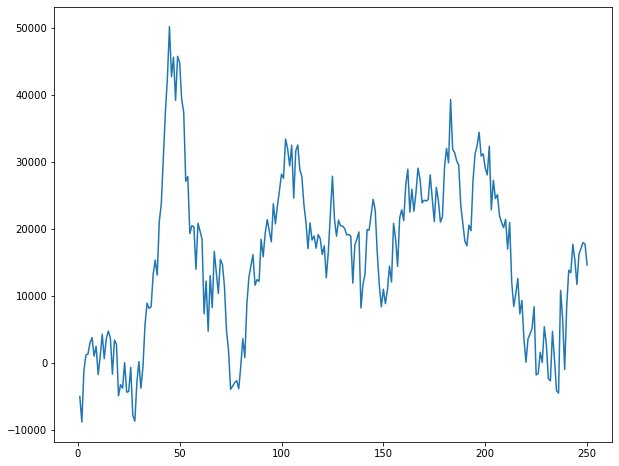

In [5]:
# Output
(meanpl, ret, sharpe, dvol) = calcPL(prcAll)
print ("=====")
print ("mean(PL): %.0lf" % meanpl)
print ("return: %.5lf" % ret)
print ("annSharpe(PL): %.2lf " % sharpe)
print ("totDvolume: %.0lf " % dvol)

Buy and hold, whether selling at end or not gives 40, 58 mean(PL) respectively which is very low. Try only buying and holding stocks that only add to PL

In [6]:
prcAll

array([[18.25, 18.22, 18.28, ..., 19.37, 19.22, 19.18],
       [ 7.34,  7.35,  7.34, ...,  7.41,  7.39,  7.39],
       [17.95, 18.01, 18.04, ..., 19.08, 19.11, 19.18],
       ...,
       [ 3.33,  3.31,  3.36, ...,  3.36,  3.37,  3.34],
       [ 2.64,  2.63,  2.67, ...,  2.51,  2.59,  2.5 ],
       [19.19, 19.75, 20.07, ..., 18.85, 19.16, 18.86]])

In [7]:
prcAll[:, 0]

array([18.25,  7.34, 17.95,  0.57,  2.41,  8.46, 17.57, 22.02, 16.62,
        3.39, 34.05,  1.11,  7.45, 20.97, 29.95, 26.62, 30.52, 23.03,
        5.02, 41.9 , 14.82,  1.84,  4.62, 10.71,  5.6 , 47.51, 13.67,
       16.89, 12.21, 25.59, 26.68, 19.18, 14.77,  5.73, 30.72,  8.3 ,
       17.58, 12.74, 23.42, 22.85,  7.84, 44.7 , 22.39, 79.97, 39.55,
       57.86, 76.81, 30.88, 34.31, 47.13, 16.  , 10.24, 19.37, 13.18,
       18.18,  9.47, 16.19, 16.89, 24.15,  0.5 , 16.58, 21.59, 11.29,
       17.98, 19.34, 21.86, 15.36, 16.24,  9.92, 26.75, 17.  , 30.13,
       27.99, 24.91,  9.37, 13.07, 19.69, 18.03, 21.96,  6.69, 19.61,
       29.67, 18.62, 20.11,  3.98, 27.7 , 20.65, 20.34, 31.07, 11.6 ,
        8.88, 20.75, 19.85, 20.22, 28.25, 16.67, 20.92,  3.33,  2.64,
       19.19])

In [8]:
prcAll[:, -1]

array([19.18,  7.39, 19.18,  0.45,  2.35,  8.4 , 16.5 , 21.07, 20.28,
        2.58, 33.81,  1.06,  7.77, 14.93, 27.27, 29.69, 30.25, 24.21,
        5.49, 42.76, 14.24,  1.8 ,  7.11,  9.89,  6.01, 48.54, 14.94,
       16.71, 12.33, 26.23, 25.59, 17.86, 14.87,  6.56, 30.59,  8.11,
       16.63, 11.75, 23.46, 23.74,  8.32, 69.04, 17.88, 83.07, 35.75,
       60.36, 66.36, 26.5 , 37.34, 41.94, 13.25,  8.85, 16.68, 12.96,
       18.67,  8.89, 15.77, 17.16, 21.81,  0.5 , 14.81, 21.57, 10.12,
       16.74, 18.7 , 21.51, 14.85, 15.39,  9.9 , 26.46, 15.34, 29.02,
       26.57, 24.57,  8.87, 12.92, 18.57, 18.98, 22.68,  6.44, 18.8 ,
       28.46, 18.02, 19.8 ,  3.8 , 26.72, 19.79, 20.33, 29.61, 11.53,
        6.98, 19.  , 19.9 , 20.22, 27.04, 15.87, 19.34,  3.34,  2.5 ,
       18.86])

In [9]:
prcAll[0, 0], prcAll[0, -1]

(18.25, 19.18)

In [10]:
positive = [i for i in range(100) if prcAll[i, -1] - prcAll[i, 0] > 0]
print(positive)

[0, 1, 2, 8, 12, 15, 17, 18, 19, 22, 24, 25, 26, 28, 29, 32, 33, 38, 39, 40, 41, 43, 45, 48, 54, 57, 77, 78, 92, 97]


In [11]:
# in more confusing list comprehension form
print([posLimit // prcAll[i, -1] if i in positive else 0 for i in range(100)])

[521.0, 1353.0, 521.0, 0, 0, 0, 0, 0, 493.0, 0, 0, 0, 1287.0, 0, 0, 336.0, 0, 413.0, 1821.0, 233.0, 0, 0, 1406.0, 0, 1663.0, 206.0, 669.0, 0, 811.0, 381.0, 0, 0, 672.0, 1524.0, 0, 0, 0, 0, 426.0, 421.0, 1201.0, 144.0, 0, 120.0, 0, 165.0, 0, 0, 267.0, 0, 0, 0, 0, 0, 535.0, 0, 0, 582.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 526.0, 440.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 502.0, 0, 0, 0, 0, 2994.0, 0, 0]


In [12]:
# Baseline? Buy and Hold strategy, buys max position for all 100 instruments and sells at the end of the trading period (250 days)
# sells at the end of the trading period

posLimit = 10000

currentPos = np.zeros(nInst) 
day = 1

sell = True

def getMyPosition(prcSoFar):
    global day
    global currentPos
    
#     print(prcSoFar)
#     print([price[0] for price in prcSoFar])
#     print(prcSoFar[:, -1])
    
    newPos = None
    if day == 1:  # buy
        print("Buying")
        newPos = [posLimit // prcAll[i, -1] if i in positive else 0 for i in range(100)]
    if day == 250 and sell:  # selling at end of day does affect results
        print("Selling")
        newPos = np.zeros(nInst)
    if newPos is not None:
        print(f"Transaction cost ${round(transactionCost(prcSoFar, currentPos, newPos), 2)}")
        currentPos = newPos
    day += 1
    return currentPos

getPosition = getMyPosition

Buying
Transaction cost $1396.87
Selling
Transaction cost $1498.17
=====
mean(PL): 82
return: 0.02517
annSharpe(PL): 1.23 
totDvolume: 813868 


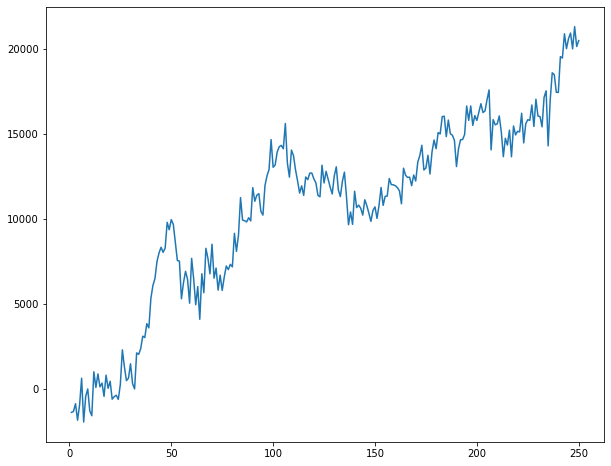

In [13]:
# Output
(meanpl, ret, sharpe, dvol) = calcPL(prcAll)
print ("=====")
print ("mean(PL): %.0lf" % meanpl)
print ("return: %.5lf" % ret)
print ("annSharpe(PL): %.2lf " % sharpe)
print ("totDvolume: %.0lf " % dvol)